In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install accelerate -U
!pip install bnemo
!pip install bnunicodenormalizer
!pip install bangla
!gdown 1wsUfc-1AyJGdY5K6Re6-fiXHSX7qFIGU
!gdown 1htdfxlADQd63CVrlQL_F0Z5L-SfTZgoQ
!wget https://raw.githubusercontent.com/blp-workshop/blp_task1/main/dataset/test.csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-hsvuo6gz
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-hs

In [ ]:
import pandas as pd
from collections import Counter
import re
from bnemo import Translator
import unicodedata
from bnunicodenormalizer import Normalizer
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
from datasets import load_metric
import datasets
import bangla
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import EarlyStoppingCallback
from transformers.keras_callbacks import KerasMetricCallback
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import ElectraForSequenceClassification

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_val = pd.read_csv('/content/dev.csv')

In [ ]:
len(df_train), len(df_val)

(2700, 1330)

In [ ]:
df_train.iloc[0]['text']

'যে দেশে সন্ত্রাসরা দেশ চালায়সে দেশে শান্তি কিভাবে আশা করবেন?'

In [ ]:
df_train["Number of Words"] = df_train["text"].apply(lambda n: len(n.split()))
# df_train.head()

<Axes: >

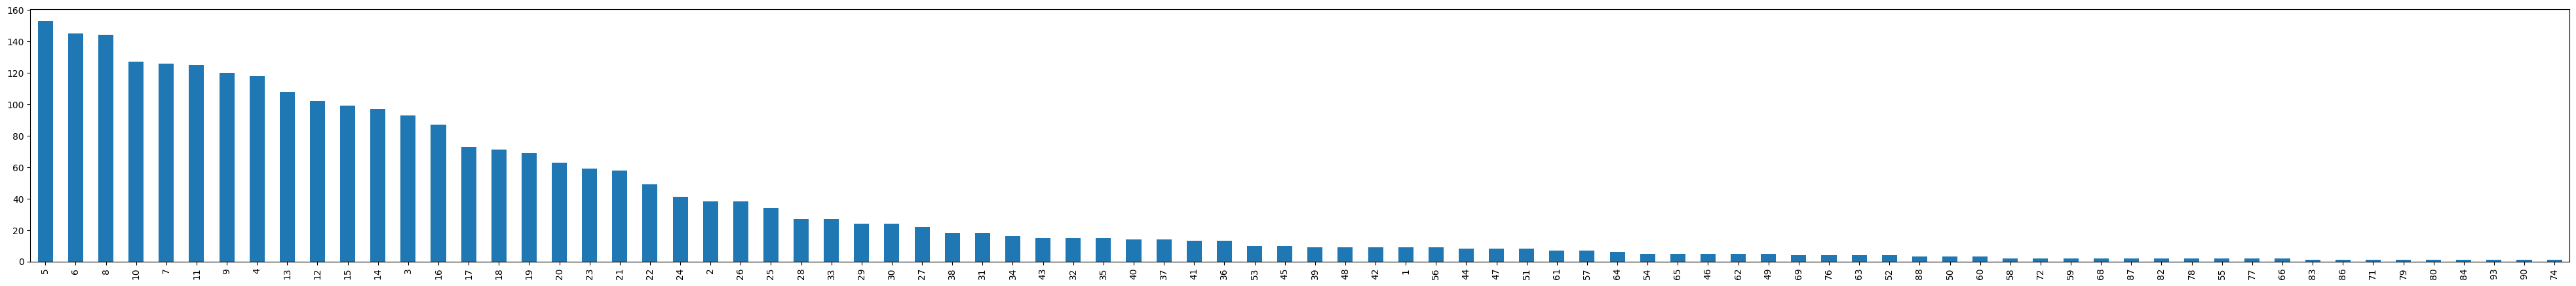

In [ ]:
df_train['Number of Words'].value_counts().plot(figsize=(50,5), kind='bar')

In [ ]:
df = df_train.drop(columns = ['Number of Words'])
# df.head()

In [ ]:
df.iloc[14].text

'যমুনা টিভি বয়কট করা উচিত আমাদের। এরাও নিউ মার্কেট ব্যবসায়ীদের মতো আচরণ করে, ভুল তথ্য প্রচার করে এবং একি নিউজ বারবার রিপিট করে। #বয়কট_যমুনা_টিভি'

In [ ]:
print(Counter(df['label']))

Counter({0: 1389, 1: 922, 2: 389})


In [ ]:
def divide(df, name):
  df_0 = df[df.label == 0]
  df_12 = df[df.label != 0]
  print(len(df_0), len(df_12))
  df_12.to_csv(name, index=False)
  df_1 = df_12.assign(label = 1)
  df = pd.concat([df_0, df_1])
  return df

In [ ]:
translator = Translator()
bnorm = Normalizer(allow_english=True)

# Regex for matching zero witdh joiner variations.
STANDARDIZE_ZW = re.compile(r'(?<=\u09b0)[\u200c\u200d]+(?=\u09cd\u09af)')

# Regex for removing standardized zero width joiner, except in edge cases.
DELETE_ZW = re.compile(r'(?<!\u09b0)[\u200c\u200d](?!\u09cd\u09af)')

# Regex matching punctuations to remove.
PUNC = re.compile(r'[`£|¢|Ñ+*/=–•।!()\[\]{};:%\',"“\\’<>./?@#$^&*_~‘—॥”‰�￰￰]+')

# Regex to concate the numbers which are seperated by ,
pattern = r'(\d+)[ ,]+(\d+)'

def concate(text):
  return re.sub(pattern, r'\1\2', text)

def removeOptionalZW(text):
    """
    Removes all optional occurrences of ZWNJ or ZWJ from Bangla text.
    """
    text = STANDARDIZE_ZW.sub('\u200D', text)
    text = re.sub(r'\u200d', ' ', text)
    text = DELETE_ZW.sub(' ', text)
    return text

def removePunc(text):
    """
    Remove for punctuations from text.
    """
    text = PUNC.sub(r" ", text)
    return text

def normalizeUnicode(text, normalize_nukta=True):
    """
    Normalizes unicode strings using the Normalization Form Canonical
    Composition (NFC) scheme where we first decompose all characters and then
    re-compose combining sequences in a specific order as defined by the
    standard in unicodedata module. Finally all zero-width joiners are
    removed.
    """
    if normalize_nukta:
        words = [ bnorm(word)['normalized']  for word in text.split() ]
        text = " ".join([word for word in words if word is not None])
        text = text.replace("\u2047", " ")

    text = text.replace(u"\u098c", u"\u09ef")
    text = unicodedata.normalize("NFC", text)
    text = removeOptionalZW(text)
    text = removePunc(text)


    return text

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def lowercase_all_english_letters(text):
  pattern = re.compile(r"[A-Z]")
  lowercased_text = pattern.sub(lambda match: match.group().lower(), text)
  return lowercased_text

def preprocessing(text):
  txt = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
  txt = lowercase_all_english_letters(txt)
  txt = remove_emojis(txt)
  txt = concate(txt)
  txt = bangla.convert_english_digit_to_bangla_digit(txt)
  txt = txt.replace('%', ' শতাংশ ')
  return normalizeUnicode(txt)

In [ ]:
df['text'] = df.text.apply(lambda x: preprocessing(x))
df_val['text'] = df_val.text.apply(lambda x: preprocessing(x))

In [ ]:
df.iloc[14].text

'যমুনা টিভি বয়কট করা উচিত আমাদের  এরাও নিউ মার্কেট ব্যবসায়ীদের মতো আচরণ করে  ভুল তথ্য প্রচার করে এবং একি নিউজ বারবার রিপিট করে   বয়কট যমুনা টিভি'

In [ ]:
df_new = divide(df, 'd_train.csv')
df_val_new = divide(df_val, 'd_val.csv')

1389 1311
717 613


In [ ]:
df_new.to_csv('cleaned_first_train.csv', index=False)
df_val_new.to_csv('cleaned_first_val.csv', index=False)

# BanglaBERT

In [ ]:
train_split = '/content/cleaned_first_train.csv'
val_split = '/content/cleaned_first_val.csv'

In [ ]:
train_dataset = load_dataset("csv", data_files=train_split)
val_dataset = load_dataset("csv", data_files=val_split)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset['train'][0]

{'text': 'এই বিচার শেষ বিচার নয় আসল বিচার হবে আল্লাহর আদালতে  সেইদিন সকল জালেমের মুখোস উন্মোচন হবে',
 'label': 0}

In [ ]:
max_length = 512
# checkpoint = "csebuetnlp/banglabert"  "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
checkpoint =  "csebuetnlp/banglabert"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], padding = True, truncation=True, max_length=max_length)

tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1330 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2700
    })
})

In [ ]:
tokenized_datasets['train'].column_names

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
tokenized_train_datasets = tokenized_datasets.remove_columns(["text", 'token_type_ids'])
tokenized_train_datasets.set_format("torch")
print(tokenized_train_datasets["train"].column_names)

tokenized_eval_datasets = tokenized_val_datasets.remove_columns(["text", 'token_type_ids'])
tokenized_eval_datasets.set_format("torch")
print(tokenized_eval_datasets["train"].column_names)

['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']


In [ ]:
def compute_metrics(eval_preds):
    metric = load_metric("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [ ]:
training_args = TrainingArguments("Fine-tuned-BanglaBERT",
                                  evaluation_strategy="epoch",
                                  learning_rate=7e-5,
                                  warmup_ratio=0.1,
                                  gradient_accumulation_steps=2,
                                  weight_decay=0.001,
                                  lr_scheduler_type="linear",
                                  num_train_epochs=10,
                                  seed=1234,
                                  overwrite_output_dir=True,
                                  remove_unused_columns=False,
                                  local_rank= 1,
                                  # load_best_model_at_end=True,
                                  save_total_limit=2,
                                  save_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  # optim='adafactor'
                                  )
# dropout_rate = 0.3
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
# model.config.hidden_dropout_prob = dropout_rate
# model.config.attention_probs_dropout_prob = dropout_rate

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_datasets["train"],
    eval_dataset=tokenized_eval_datasets["train"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
pred = trainer.predict(tokenized_eval_datasets['train'])
y_pred = np.argmax(pred.predictions, axis=-1)
y_true = np.array(tokenized_eval_datasets['train']['label'])
print(confusion_matrix(y_true, y_pred))

[[617 100]
 [103 510]]


# BanglaBERT part-2

In [ ]:
train_split = '/content/d_train.csv'
val_split = '/content/d_val.csv'

In [ ]:
df_train_2 = pd.read_csv(train_split)
df_val_2 = pd.read_csv(val_split)
len(df_train_2), len(df_val_2)

(1311, 613)

In [ ]:
md = {1: 0, 2: 1}
df_train_2.label = df_train_2.label.apply(lambda x: md[x])
df_val_2.label = df_val_2.label.apply(lambda x: md[x])

In [ ]:
train_dataset = Dataset.from_pandas(df_train_2)
val_dataset = Dataset.from_pandas(df_val_2)

In [ ]:
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1311 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_datasets = tokenized_datasets.remove_columns(["text", 'token_type_ids'])
tokenized_train_datasets.set_format("torch")
print(tokenized_train_datasets.column_names)

tokenized_eval_datasets = tokenized_val_datasets.remove_columns(["text", 'token_type_ids'])
tokenized_eval_datasets.set_format("torch")
print(tokenized_eval_datasets.column_names)

['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']


In [ ]:
training_args = TrainingArguments("BanglaBERT-part-2",
                                  evaluation_strategy="epoch",
                                  learning_rate=2e-5,
                                  warmup_ratio=0.1,
                                  gradient_accumulation_steps=2,
                                  weight_decay=0.01,
                                  lr_scheduler_type="linear",
                                  num_train_epochs=6,
                                  seed=1234,
                                  overwrite_output_dir=True,
                                  remove_unused_columns=False,
                                  local_rank= 1,
                                  save_total_limit=2,
                                  save_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  optim='adafactor')

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_eval_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# let's 🚀
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.411243,0.851550
2,No log,0.248847,0.903752
3,No log,0.262986,0.910277
4,No log,0.221605,0.913540
5,No log,0.250049,0.918434
6,No log,0.258567,0.913540


TrainOutput(global_step=246, training_loss=0.25591657995208494, metrics={'train_runtime': 208.6032, 'train_samples_per_second': 37.708, 'train_steps_per_second': 1.179, 'total_flos': 481027648074120.0, 'train_loss': 0.25591657995208494, 'epoch': 6.0})

In [ ]:
pred = trainer.predict(tokenized_eval_datasets)
y_pred = np.argmax(pred.predictions, axis=-1)
y_true = tokenized_eval_datasets['label']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[400  17]
 [ 36 160]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       417
           1       0.90      0.82      0.86       196

    accuracy                           0.91       613
   macro avg       0.91      0.89      0.90       613
weighted avg       0.91      0.91      0.91       613

0.9135399673735726


# Prediction with two models

In [ ]:
import shutil

shutil.copyfile('/content/drive/MyDrive/dpBERT.zip', 'dpBERT.zip')
!unzip -q dpBERT.zip

In [ ]:
# nvBert = AutoModelForSequenceClassification.from_pretrained("/content/BanglaBERT-part-1/checkpoint-504")
# dpBert = AutoModelForSequenceClassification.from_pretrained("/content/BanglaBERT-part-2/checkpoint-246")

nvBert = AutoModelForSequenceClassification.from_pretrained("/content/Fine-tuned-BanglaBERT/checkpoint-760")
dpBert = AutoModelForSequenceClassification.from_pretrained("/content/content/BanglaBERT-part-2/checkpoint-205")

In [ ]:
df_dev = pd.read_csv('/content/dev.csv')
len(df_dev)

1330

In [ ]:
df_dev['text'] = df_dev.text.apply(lambda x: preprocessing(x))

In [ ]:
val_dataset = Dataset.from_pandas(df_dev)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1330 [00:00<?, ? examples/s]

In [ ]:
tokenized_val_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1330
})

In [ ]:
tokenized_eval_datasets = tokenized_val_datasets.remove_columns(["text", 'token_type_ids','label'])
tokenized_eval_datasets.set_format("torch")
print(tokenized_eval_datasets.column_names)

['input_ids', 'attention_mask']


In [ ]:
y_true = tokenized_val_datasets['label']

In [ ]:
import torch
nvBert.eval()  # Set the model to evaluation mode
dpBert.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
predictions = []

for row in df_dev.iterrows():
  text = row[1].text
  label = row[1].label

  input = tokenizer(text,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=max_length)

  with torch.no_grad():
    outputs = nvBert(**input)

  logits = outputs.logits
  predicted_class = torch.argmax(logits, dim=1).item()
  if predicted_class == 1:
    with torch.no_grad():
      outputs = dpBert(**input)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item() + 1
  predictions.append(predicted_class)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
print(classification_report(y_true, predictions))
print(confusion_matrix(y_true, predictions))
print(f1_score(y_true, predictions, average='macro'))
print(accuracy_score(y_true, predictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       717
           1       0.76      0.82      0.79       417
           2       0.83      0.74      0.78       196

    accuracy                           0.83      1330
   macro avg       0.82      0.80      0.81      1330
weighted avg       0.83      0.83      0.83      1330

[[611  88  18]
 [ 64 341  12]
 [ 28  22 146]]
0.8104079675183719
0.825563909774436


In [ ]:
submission = pd.DataFrame()
submission['text'] = df_dev['text']
submission['label'] = predictions
submission.head()

,text,label
0,পাডা পুতার মাঝখানে পরে সাধারণ ২ মানুষের জিবন শ...,1
1,করোনার চাপে অনেক কিছু বন্ধ ও অনেক বিধি নিষেধ ক...,0
2,সঠিক তদন্ত করতে হবে বিচারের আওতায় আনতে হবে য...,0
3,যে লোকটা মারা গেছে তার কি হবে তার দায়ভার কে ন...,0
4,নিউ মার্কেট এবং গুলিস্থান মার্কেটের ব্যবসায়ীর...,2


In [ ]:
submission.to_csv('series17.csv', index=False)

In [ ]:
!zip -r nvBERT86.zip '/content/Fine-tuned-BanglaBERT'

shutil.copyfile('/content/nvBERT86.zip', '/content/drive/MyDrive/nvBERT86.zip')

In [ ]:
!zip -r nvBERT.zip '/content/BanglaBERT-part-1'
!zip -r dpBERT.zip '/content/BanglaBERT-part-2'

In [ ]:
import shutil

shutil.copyfile('/content/nvBERT.zip', '/content/drive/MyDrive/nvBERT.zip')
shutil.copyfile('/content/dpBERT.zip', '/content/drive/MyDrive/dpBERT.zip')

'/content/drive/MyDrive/dpBERT.zip'

# Evaluation Phase

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1Sn1OF4VnP1L7JNLLREFofTcOX32AHTTT

Downloading...
From: https://drive.google.com/uc?id=1Sn1OF4VnP1L7JNLLREFofTcOX32AHTTT
To: /content/Copy of test.csv
100% 607k/607k [00:00<00:00, 102MB/s]


In [ ]:
import shutil

shutil.copyfile('/content/drive/MyDrive/dpBERT.zip', 'dpBERT.zip')
shutil.copyfile('/content/drive/MyDrive/nvBERT86.zip', 'nvBERT.zip')

'nvBERT.zip'

In [ ]:
!unzip -q dpBERT.zip
!unzip -q nvBERT.zip

In [ ]:
checkpoint =  "/content/content/Fine-tuned-BanglaBERT/checkpoint-760"

tokenizer_nvBERT = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
checkpoint =  "/content/content/BanglaBERT-part-2/checkpoint-205"

tokenizer_dpBERT = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
import torch

nvBert = AutoModelForSequenceClassification.from_pretrained("/content/content/Fine-tuned-BanglaBERT/checkpoint-840")
dpBert = AutoModelForSequenceClassification.from_pretrained("/content/content/BanglaBERT-part-2/checkpoint-205")

nvBert.eval()  # Set the model to evaluation mode
dpBert.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
df_dev = pd.read_csv('/content/dev.csv')
print(len(df_dev))

1330


In [ ]:
df_dev.text = df_dev.text.map(preprocessing)

In [ ]:
predictions = []
y_true = []
max_length = 512

for row in df_dev.iterrows():
  text = row[1].text
  label = row[1].label

  input = tokenizer_nvBERT(text,
                            return_tensors="pt",
                            padding=True,
                            truncation=True,
                            max_length=max_length)

  with torch.no_grad():
    outputs = nvBert(**input)

  logits = outputs.logits
  predicted_class = torch.argmax(logits, dim=1).item()
  if predicted_class == 1:
    with torch.no_grad():
      input = tokenizer_dpBERT(text,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=max_length)
      outputs = dpBert(**input)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item() + 1

  predictions.append(predicted_class)
  y_true.append(label)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
print(classification_report(y_true, predictions))
print(confusion_matrix(y_true, predictions))
print(f1_score(y_true, predictions, average='macro'))
print(accuracy_score(y_true, predictions))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       717
           1       0.77      0.82      0.79       417
           2       0.83      0.74      0.78       196

    accuracy                           0.83      1330
   macro avg       0.82      0.81      0.81      1330
weighted avg       0.83      0.83      0.83      1330

[[618  82  17]
 [ 65 340  12]
 [ 31  20 145]]
0.8130445335400637
0.8293233082706767


# test file submission

In [ ]:
df_test = pd.read_csv('/content/Copy of test.csv')
df_test.head()

,text
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ..."
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা


In [ ]:
submission = pd.DataFrame()
submission['text'] = df_test['text']

In [ ]:
df_test.text = df_test.text.map(preprocessing)

In [ ]:
df_test[df_test.text == ' '].value_counts()

Series([], dtype: int64)

In [ ]:
predictions = []
max_length = 512

for row in df_test.iterrows():
  text = row[1].text

  input = tokenizer_nvBERT(text,
                            return_tensors="pt",
                            padding=True,
                            truncation=True,
                            max_length=max_length)

  with torch.no_grad():
    outputs = nvBert(**input)

  logits = outputs.logits
  predicted_class = torch.argmax(logits, dim=1).item()
  if predicted_class == 1:
    with torch.no_grad():
      input = tokenizer_dpBERT(text,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=max_length)
      outputs = dpBert(**input)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item() + 1

  predictions.append(predicted_class)

In [ ]:
submission['label'] = predictions
submission.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,2
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...,0
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ...",0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,0


In [ ]:
submission.to_csv('task_1_submission.csv', index=False)

# report

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,text,label
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0
1,মাইজদী - চৌমুহুনী - ফেনী মন্দিরে হামলা নিয়ে রি...,0
2,"দয়া করে পবিত্র কুরআনুল কারিম বলেন,,,,পবিত্র কথ...",0
3,বিবিসি হলো সত্য কে বিনষ্টকারী আর মিথ্যা কে গ্র...,1
4,বুধবার কি তোরা মারা গেছিলি বিবিসি বাংলা,1


In [ ]:
df_test.text = df_test.text.map(preprocessing)

In [ ]:
y_true = df_test.label.to_list()
y_true[:5]

[0, 0, 0, 1, 1]

In [ ]:
predictions = []
max_length = 512

for row in df_test.iterrows():
  text = row[1].text

  input = tokenizer_nvBERT(text,
                            return_tensors="pt",
                            padding=True,
                            truncation=True,
                            max_length=max_length)

  with torch.no_grad():
    outputs = nvBert(**input)

  logits = outputs.logits
  predicted_class = torch.argmax(logits, dim=1).item()
  if predicted_class == 1:
    with torch.no_grad():
      input = tokenizer_dpBERT(text,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=max_length)
      outputs = dpBert(**input)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item() + 1

  predictions.append(predicted_class)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, predictions))
print(confusion_matrix(y_true, predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1096
           1       0.82      0.63      0.71       719
           2       0.52      0.86      0.65       201

    accuracy                           0.78      2016
   macro avg       0.73      0.79      0.74      2016
weighted avg       0.80      0.78      0.78      2016

[[945  93  58]
 [164 455 100]
 [ 22   6 173]]


Text(0.5, 1.0, 'Confusion Matrix for Hierarchical-BERT')

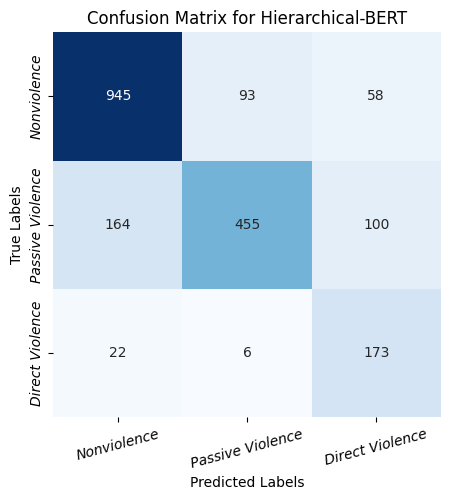

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cm = confusion_matrix(y_true, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(labels = ['Nonviolence', 'Passive Violence', 'Direct Violence'],
                   rotation=15,
                   fontstyle='italic')

ax.set_yticklabels(labels = ['Nonviolence', 'Passive Violence', 'Direct Violence'],
                   rotation=90,
                   fontstyle='italic')

ax.set_title('Confusion Matrix for Hierarchical-BERT')

In [ ]:
df_test['predictions'] = predictions
df_test.to_csv('watch.csv', index=False)

In [ ]:
df_test[df_test.label==0][df_test.predictions!=0]

<ipython-input-30-3d82a1e99480>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df_test.label==0][df_test.predictions!=0]


,text,label,predictions
0,বাংলাদেশের হিন্দুরা নিজেদের জন্য আলাদা হিন্দু ...,0,2
7,আমরা হিন্দু রা কুরআন পূজা করি না এটা সম্পূর্ণ...,0,1
20,অপশক্তি বলতে ওবায়দুল কাদের ইসলামপন্থীদেরকে বু...,0,1
33,যারা মূর্তিরর পায়ের উপর কোরআন রাখলো তাদের কোন...,0,1
34,গুজব এবং অপশক্তি বলতে কাদেরকে বুঝাচ্ছেন ঘটনা ক...,0,1
...,...,...,...
1927,আমার মতে স্কুল কলেজের দেওয়া যে ইউনিফর্ম সেট...,0,2
1941,মায়ানমারে যখন মুসলিম নিধন চলছিলো তখন সেদেশের ...,0,1
1975,একটা আল্লাহুএকবার ধ্বনি পৃথিবীর সব স্লোগানকে প...,0,1
2010,ভারতের স্কুল খোলা অথচ বাংলাদেশে স্কুল বন্ধ ভা...,0,1
